In [46]:
%matplotlib inline
from obspy import read_inventory
import pandas as pd
import numpy as np

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.io.img_tiles as cimgt

import tempmatch as tm
from obspy import UTCDateTime as UTC
from obspy.signal import filter
import obspy

# Network deployment

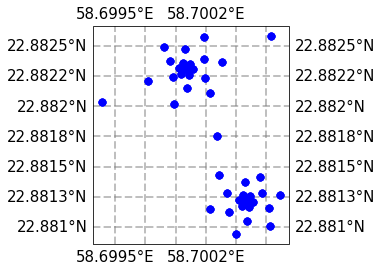

In [2]:
inventory = read_inventory('fdsn-station_2021-06-29T11_00_50.xml', format="STATIONXML")
channels = inventory.networks[0].get_contents()['channels']
networkdf = pd.DataFrame([inventory.get_coordinates(seed_id=id) for id in channels], index=[id for id in channels])

proj = ccrs.PlateCarree()                       # the projection you want to use, many are supported, 
                                                # this one is the standard for geographic coordinates
    
ax = plt.axes(projection=proj)                  # sets the projection

ax.coastlines(resolution='110m')                # the level of resolution to render the drawings, 
                                                # see documentation for more details
    
gl = ax.gridlines(crs=ccrs.PlateCarree()        
                , draw_labels=True              # label coordinates
                , linewidth=2                   # line properties can be changed similar to matplotlib
                , color='gray'
                , alpha=0.5
                , linestyle='--')

       
gl.xlabel_style = {'size': 15}                                     # change label font sizes
gl.ylabel_style = {'size': 15}

ax.plot(networkdf.longitude, networkdf.latitude                                             # mark a known place to help us geo-locate ourselves
        , 'bo'
        , markersize=7
        , transform=ccrs.Geodetic())

This shows the entire geophone and hydrophone network. The hydrophone stations are at the center of each star.

# template matching

To detect the bubble cavitation events, we develop a template matching (matched filter) algorithm using the built-in obspy template matching. These codes run in parallel and do not run in a jupyter notebook. They can be found in `finalcatalog_b00.allphones.py`. This produces a series of files that contain the detections, per day that are found at `/media/sda/data/borehole/detections/*.csv`.

`finalcatalog_b00.allphyones.py` works by creating a single template from all six hydrophones and scanning through the data per day for all six hydrophones. The process is parallized to ten threads (more then this uses too much memory). There doesn't need to be more than one template because bubble cavitation signals are more or less identical.

There are a number of things to remember when doing the template matching:

1. hydrophone 4 on BA1B needs to be flipped (times by -1) because the leads on the hydrophone were connected incorrectly
2. a detection happens if the AVERAGE cross-correlation score (called the height by obspy) is >=0.8
3. detections are not made for events that start less than 1.1s between each other. This is due to the wave reflection. Events that are within 1.1s could be reflections of an original wave.
4. on a 10-core (20 threads), 128GB ram computer this takes approximately half an hour.
5. events are located per day, the continous waveform data is organized per day, therefore days are searched with the template matching in parallel. Detections are then written to file for files per day.

# Importing detections to make bubble measurements

In [3]:
detectfiles = !ls /media/sda/data/borehole/detections/*.csv

df = pd.DataFrame()
for f in detectfiles:
    try:
        df = pd.concat([df, pd.read_csv(f)])
    except:
        pass
    
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(by='time')
df['ones'] = 1
df.set_index('time', inplace=True)
# df.to_csv('proposal/cumevents.csv')

Text(0, 0.5, 'cumulative number of events')

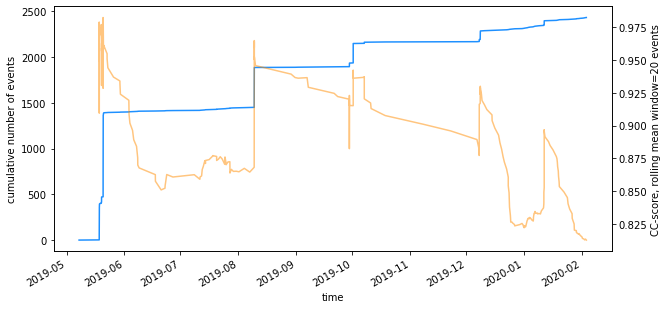

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
df.cumsum()['ones'].plot(ax=ax, color='dodgerblue')

ax2 = ax.twinx()
df.similarity.rolling(window=20).mean().plot(ax=ax2, color='darkorange', alpha=0.5)
ax2.set_ylabel('CC-score, rolling mean window=20 events')
# ax.set_yscale('log')
ax.set_ylabel('cumulative number of events')

(-1.0, 2501.0)

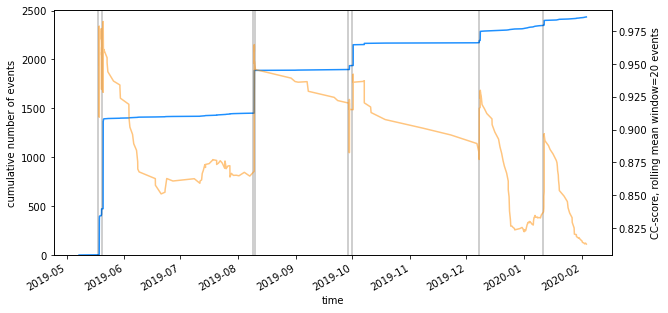

In [47]:
# For BA1B, the spectrogram stripes are on days:

# 2019: 122, 123, 138, 140, 221, 222, 272, 274, 297, 342
# 2020: 7, 10, 11, 33

fig, ax = plt.subplots(figsize=(10, 5))
df.cumsum()['ones'].plot(ax=ax, color='dodgerblue')

ax2 = ax.twinx()
df.similarity.rolling(window=20).mean().plot(ax=ax2, color='darkorange', alpha=0.5)
ax2.set_ylabel('CC-score, rolling mean window=20 events')
# ax.set_yscale('log')
ax.set_ylabel('cumulative number of events')

days = dict(
# day122 = pd.to_datetime('2019-05-02'),
# day123 = pd.to_datetime('2019-05-03'),
day138 = pd.to_datetime('2019-05-18'),
day140 = pd.to_datetime('2019-05-20'),
day221 = pd.to_datetime('2019-08-09'),
day222 = pd.to_datetime('2019-08-10'),
day272 = pd.to_datetime('2019-09-29'),
day274 = pd.to_datetime('2019-10-01'),
# day297 = pd.to_datetime('2019-10-24'),
day342 = pd.to_datetime('2019-12-08'),
# day007 = pd.to_datetime('2020-01-07'),
day010 = pd.to_datetime('2020-01-11'),
# day033 = pd.to_datetime('2020-02-02'),
)

for k in days.keys():
    ts = days[k]
    ax.plot([ts, ts], [-10, 2600], color='black', alpha=0.25)
    
ax.set_ylim(-1, 2501)

This plot differs from the previous one in only that it also highlights the days which we expect there to be degassing events based on the

<AxesSubplot:xlabel='time'>

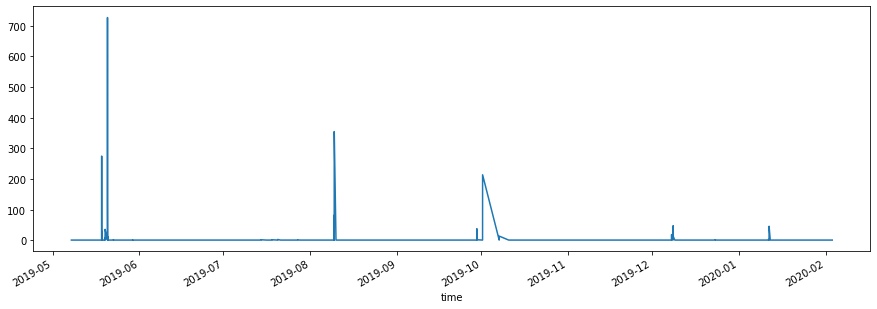

In [48]:
df.rolling(window='30min').sum()['ones'].plot(figsize=(15, 5))

/tmp/ipykernel_26160/369196311.py:3: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  df.truncate(start, end).rolling(window='2min').sum()['ones'].plot(figsize=(15, 5))


<AxesSubplot:xlabel='time'>

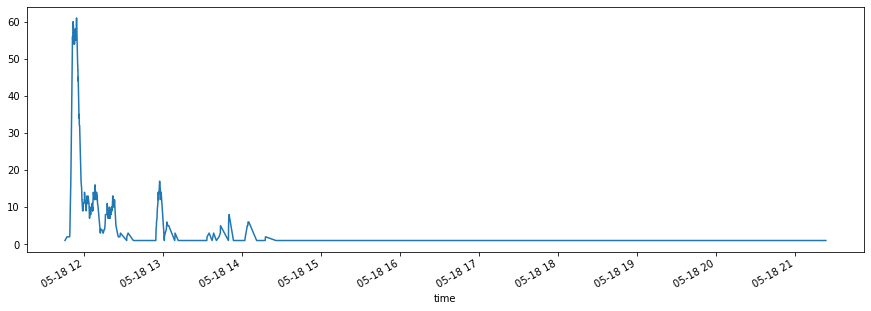

In [49]:
start = pd.to_datetime('05-18-2019')
end = pd.to_datetime('05-19-2019')
df.truncate(start, end).rolling(window='2min').sum()['ones'].plot(figsize=(15, 5))

# power spectra

In order to calculate the power spectra for a few bubbles so we can get their dominant frequencies to calculated the Minneart relationship to find their volumes, I needed to pick some randomly. The code below does this.

In [42]:
def get_raw_data_for_event(event):
    ts = event.index[0]
    year = ts.year
    day = ts.day_of_year
    ts = UTC(ts)
    if year == 2020:
        day = '0'+str(day)
    dirstr = '/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.{y}.{d}'.format(y=year, d=day)
    data = obspy.read(dirstr)
    data.trim(starttime=ts, endtime=ts+0.25)
    return data

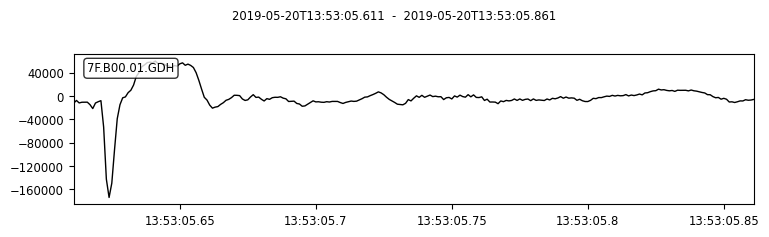

In [44]:
_ = get_raw_data_for_event(df.sample()).plot()

In [ ]:
for s in np.arange(0, 10, 1):
    e = df.sample()
    data = get_raw_data_for_event(e)
    times = data[0].times()
    d = data[0].data
    writeable_df = pd.DataFrame({'data':d,'times':times})
    starttime = str(e.index[0]).split('+')[0]
    # writeable_df.to_csv('events_for_rob/'+starttime+'.csv', index=False)

# tremor

We have detected tremor in hole BA1A that we believe may be due to the gas/liquid mixture migrating towards the borehole prior to the degassing. This would mean there are migration pathways in the area.

# add more stuff here about the cumulative tremor stuff